# Введение в обработку естественного языка
# Урок 10. Машинный перевод. Модель seq2seq и механизм внимания

# <font color='red'>Практическое задание</font>

### Домашнее задание к уроку 10

__Задание__<br>
Разобраться с моделькой перевода как она устроена<br>
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке)

Выполнил ___Соковнин ИЛ___

# Neural machine translation

In [8]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset
## Загрузка и установка датасета

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-06-25 15:32:24--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  67.5MB/s    in 0.2s    

2022-06-25 15:32:24 (67.5 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [3]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 71M
drwxr-xr-x 2 root root 4.0K Jun 25 15:32 .
drwxr-xr-x 1 root root 4.0K Jun 25 15:32 ..
-rw-r--r-- 1 root root 1.5K May  2 01:29 _about.txt
-rw-r--r-- 1 root root  71M May  2 01:29 rus.txt


In [5]:
# Download the file
path_to_file = "/content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
  
  # strip() - возвращает копию строки с удаленными начальными и конечными символами (https://pythonstart.ru/string/strip-python). 
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'

  return w

In [9]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [10]:
# 1. Remove the accents (Убираем акценты)
# 2. Clean the sentences (Очистите предложения)
# 3. Return word pairs in the format: [ENG, RUS] (Вернуть пары слов в формате: [ENG, RUS])
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [11]:
lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
num_examples = 1

for l in lines[:num_examples]:
  for w in l.split('\t')[:2]:
    print(preprocess_sentence(w))

<start> go . <end>
<start> марш ! <end>


In [12]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [13]:
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [14]:
def tokenize(lang):
  """ 
    Токенизация текста

    https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
  
  """

  # Служебный класс для токенизации текста.
  # Этот класс позволяет векторизовать текстовый корпус.
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  
  lang_tokenizer.fit_on_texts(lang)  # Обновляет внутренний словарь на основе списка текстов.

  tensor = lang_tokenizer.texts_to_sequences(lang)  # Transforms each text in texts to a sequence of integers

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')  # Pads sequences to the same length (post - after).

  return tensor, lang_tokenizer

In [15]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)
### Ограничим размер датасета для ускорения эксперимента (опционально)

In [16]:
len(en), len(ru)

(444587, 444587)

In [17]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [18]:
max_length_targ, max_length_inp

(11, 15)

In [19]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [20]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [21]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
30 ----> как
210 ----> этим
10386 ----> пользуются
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
49 ----> how
15 ----> do
4 ----> i
271 ----> use
19 ----> this
6 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [26]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

# <font color='red'>Neural machine translation</font>

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [28]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state

In [29]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

In [30]:
decoder_sample_x.shape

TensorShape([64, 7334])

In [31]:
decoder_sample_h.shape

TensorShape([64, 1024])

## Define the optimizer and the loss function

In [32]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)
## Контрольные точки (Object-based saving)

In [33]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Обучение модели

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [36]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5258
Epoch 1 Batch 100 Loss 2.0305
Epoch 1 Batch 200 Loss 1.7621
Epoch 1 Batch 300 Loss 1.5777
Epoch 1 Batch 400 Loss 1.5404
Epoch 1 Batch 500 Loss 1.4149
Epoch 1 Batch 600 Loss 1.3890
Epoch 1 Batch 700 Loss 1.2275
Epoch 1 Batch 800 Loss 1.2151
Epoch 1 Batch 900 Loss 1.0821
Epoch 1 Batch 1000 Loss 1.1432
Epoch 1 Batch 1100 Loss 1.1177
Epoch 1 Batch 1200 Loss 1.0775
Epoch 1 Loss 1.4569
Time taken for 1 epoch 61.77876329421997 sec

Epoch 2 Batch 0 Loss 0.8406
Epoch 2 Batch 100 Loss 0.9508
Epoch 2 Batch 200 Loss 0.8073
Epoch 2 Batch 300 Loss 0.8821
Epoch 2 Batch 400 Loss 0.8762
Epoch 2 Batch 500 Loss 0.7596
Epoch 2 Batch 600 Loss 0.7469
Epoch 2 Batch 700 Loss 0.6980
Epoch 2 Batch 800 Loss 0.6986
Epoch 2 Batch 900 Loss 0.6855
Epoch 2 Batch 1000 Loss 0.7281
Epoch 2 Batch 1100 Loss 0.6244
Epoch 2 Batch 1200 Loss 0.5478
Epoch 2 Loss 0.7318
Time taken for 1 epoch 55.153178215026855 sec

Epoch 3 Batch 0 Loss 0.3850
Epoch 3 Batch 100 Loss 0.3833
Epoch 3 Batch 200 Loss 0.37

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [37]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [38]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [40]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's fine here . <end> 


In [41]:
translate('Отлично, поехали.')

Input: <start> отлично , поехали . <end>
Predicted translation: ok , let's go . <end> 


In [42]:
translate(u'Вы еще дома?')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still at home ? <end> 


In [43]:
translate(u'Это слишком дорого для меня.?')

Input: <start> это слишком дорого для меня . ? <end>
Predicted translation: that's too much for me . <end> 


In [44]:
translate(u'Попробуй сделать это.')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do that . <end> 


In [45]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i like it dark . <end> 


In [46]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


In [47]:
translate('А счастье было так возможно, так близко!.')

Input: <start> а счастье было так возможно , так близко ! . <end>
Predicted translation: it was cheap . <end> 


In [48]:
translate('Интересно, а если написать длинное предложение и попробовать его перевести, какой результат мы увидим?')

Input: <start> интересно , а если написать длинное предложение и попробовать его перевести , какой результат мы увидим ? <end>
Predicted translation: do you also like jazz ? <end> 


__Вывод:__<br>

При увеличении длины текста, качество перевода резко падает. Перевод последнего предложения соответствует последнему предложению.

# <font color='red'>Neural machine translation with attention</font>

In [49]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [52]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [53]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [54]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


## Define the optimizer and the loss function

In [55]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [56]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [58]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [59]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8045
Epoch 1 Batch 100 Loss 2.0884
Epoch 1 Batch 200 Loss 1.8418
Epoch 1 Batch 300 Loss 1.7152
Epoch 1 Batch 400 Loss 1.5148
Epoch 1 Batch 500 Loss 1.5344
Epoch 1 Batch 600 Loss 1.5292
Epoch 1 Batch 700 Loss 1.2826
Epoch 1 Batch 800 Loss 1.2203
Epoch 1 Batch 900 Loss 1.1733
Epoch 1 Batch 1000 Loss 1.1406
Epoch 1 Batch 1100 Loss 1.1039
Epoch 1 Batch 1200 Loss 1.0212
Epoch 1 Loss 1.4665
Time taken for 1 epoch 112.27705335617065 sec

Epoch 2 Batch 0 Loss 0.7619
Epoch 2 Batch 100 Loss 0.9176
Epoch 2 Batch 200 Loss 0.8496
Epoch 2 Batch 300 Loss 0.7899
Epoch 2 Batch 400 Loss 0.7839
Epoch 2 Batch 500 Loss 0.5027
Epoch 2 Batch 600 Loss 0.5773
Epoch 2 Batch 700 Loss 0.5510
Epoch 2 Batch 800 Loss 0.4571
Epoch 2 Batch 900 Loss 0.5641
Epoch 2 Batch 1000 Loss 0.4982
Epoch 2 Batch 1100 Loss 0.4282
Epoch 2 Batch 1200 Loss 0.5782
Epoch 2 Loss 0.6369
Time taken for 1 epoch 98.50651812553406 sec

Epoch 3 Batch 0 Loss 0.2793
Epoch 3 Batch 100 Loss 0.2951
Epoch 3 Batch 200 Loss 0.34

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [60]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [61]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [62]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [63]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> здесь хорошо . <end>
Predicted translation: it's fine here . <end> 


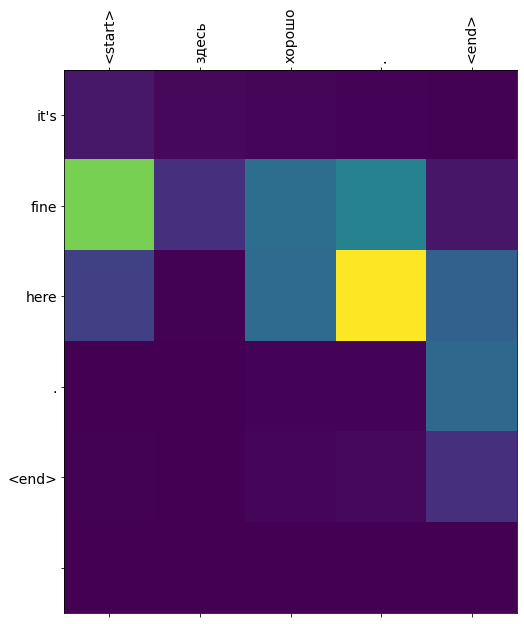

In [64]:
translate('Здесь хорошо.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


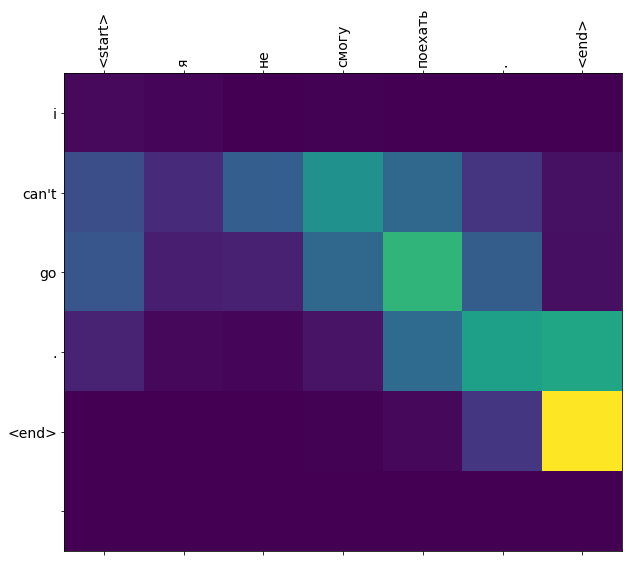

In [65]:
translate('Я не смогу поехать.')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


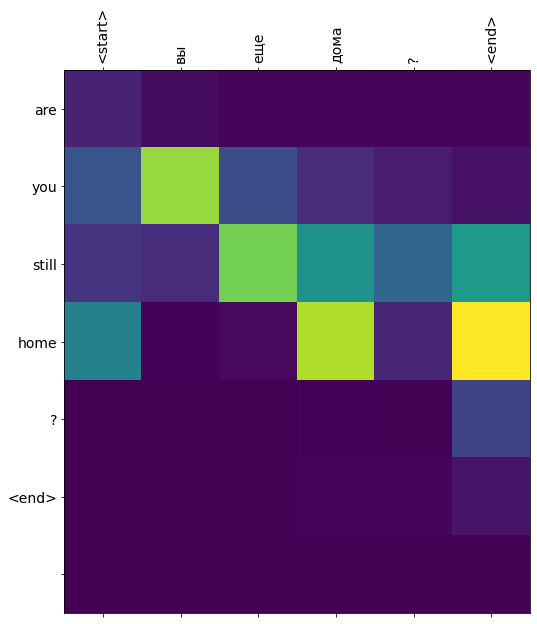

In [66]:
translate(u'Вы еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you still at home ? <end> 


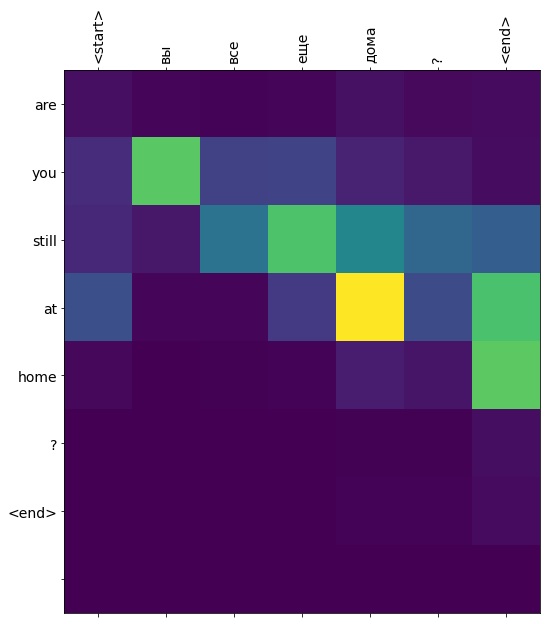

In [67]:
translate(u'Вы все еще дома?')

Input: <start> попробуй сделать это . <end>
Predicted translation: try doing it fixed . <end> 


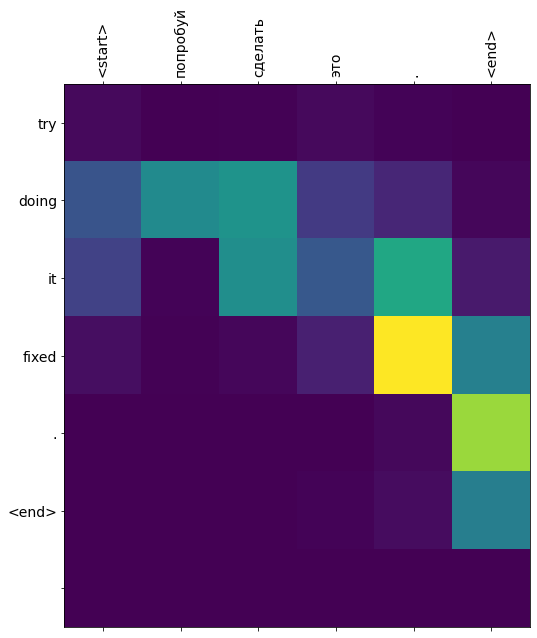

In [68]:
translate(u'Попробуй сделать это.')

Input: <start> попробуй сделать это . <end>
Predicted translation: try doing it fixed . <end> 


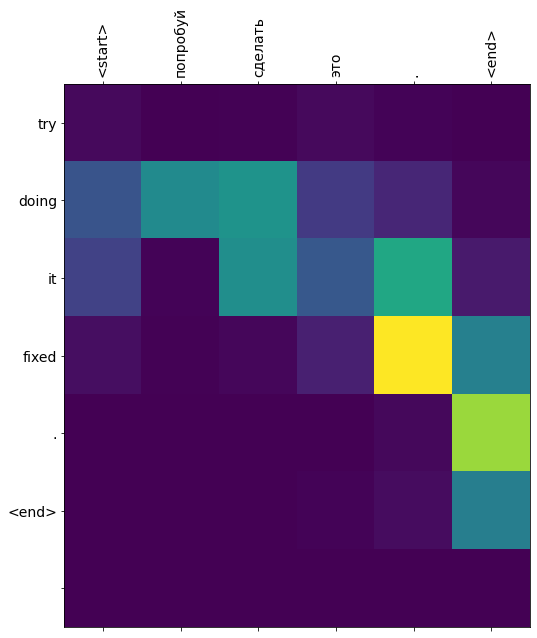

In [69]:
translate(u'Попробуй сделать это.')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't like snow . <end> 


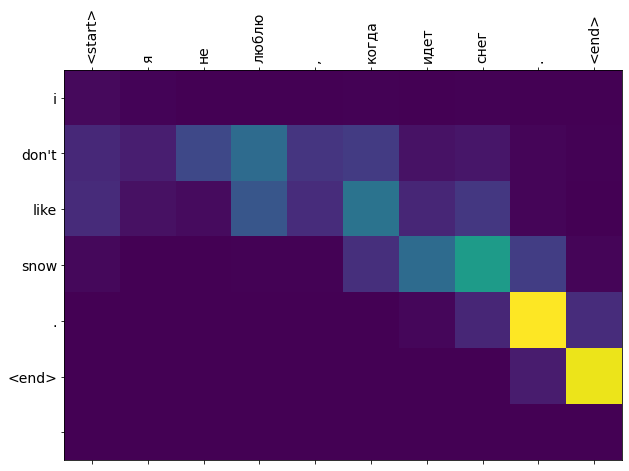

In [70]:
translate(u'Я не люблю, когда идет снег.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


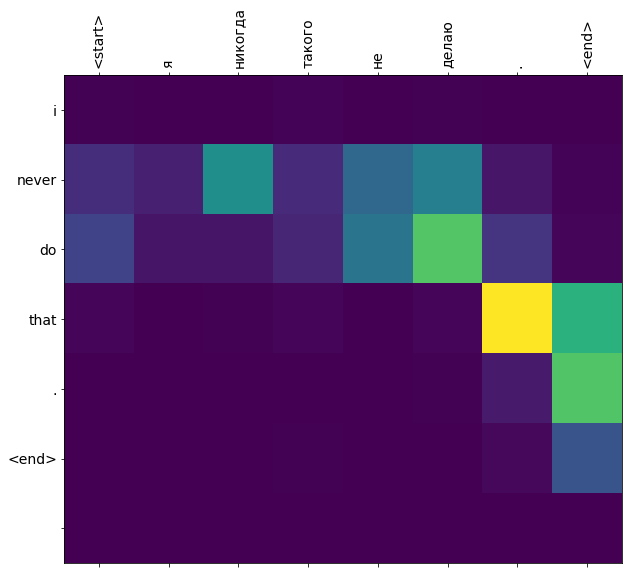

In [71]:
translate(u'Я никогда такого не делаю.')

Input: <start> интересно , а если написать длинное предложение и попробовать его перевести , какой результат мы увидим ? <end>
Predicted translation: i have to act . <end> 


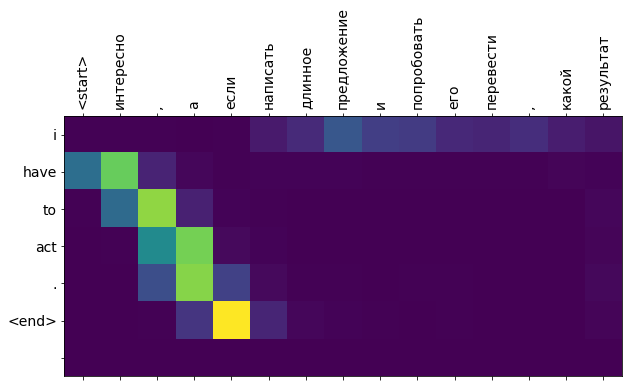

In [72]:
translate(u'Интересно, а если написать длинное предложение и попробовать его перевести, какой результат мы увидим?')

__Вывод:__<br>

При увеличении длины текста, качество перевода резко падает. Перевод не соответствует последнему предложению.